In [1]:
import pandas as pd

Raw df from csv files

In [2]:
allergy_customer = pd.read_csv("ODL_ALLERGY_CUSTOMER.csv", usecols=["allergy_id","customer_id"])
allergy = pd.read_csv("ODL_ALLERGY.csv", usecols=["data_id","severity", "name"])
restaurant = pd.read_csv("ODL_RESTAURANT.csv", usecols=["data_id", "name", "opening_hours", "city", "street", "phone_number", "creation_date", "email"])
order = pd.read_csv("ODL_ORDER.csv", usecols=["restaurant_id", "creation_date", "customer_id", "data_id"])
orderables = pd.read_csv("ODL_ORDERABLES.csv", usecols=["price", "restaurant_id", "data_id", "name"])
order_item = pd.read_csv("ODL_ORDER_ITEM.csv", usecols=["order_id", "amount", "data_id", "orderable_id"])

Quick cleaning

In [3]:
allergy = allergy.drop_duplicates(subset="data_id")

In [4]:
def correct_data(row):
    if pd.isnull(row["customer_id"]):
        data = row["allergy_id"].split(";")
        row["allergy_id"] = int(data[0])
        row["customer_id"] = int(data[1])
    else: 
        row["customer_id"] = int(row["customer_id"])
        row["allergy_id"] = int(row["allergy_id"])
    return row

allergy_customer = allergy_customer.apply(correct_data, axis = 1)

We add informations to several tables by merging data, etc.

First, add a price col to order_item and total amount col as well.

In [5]:
order_item = order_item.join(orderables.set_index("data_id"), on="orderable_id")
order_item["total"] = order_item["amount"] * order_item["price"]

Now we compute the total amount spend per order and add it to the table. We add the city as well.

In [6]:
order_tot = order_item[["order_id","total"]].groupby("order_id").sum()
order = order.join(order_tot, on="data_id")
order = order.join(restaurant[["data_id","city"]].set_index("data_id"), on="restaurant_id")

We add allergy info per order

In [7]:
allergic_customer = set(allergy_customer["customer_id"].tolist())

In [8]:
order["is_allergic"] = order["customer_id"].map(lambda x: (x in allergic_customer))

Some orders have no items (we interpret this as a cancelled order). We keep a copy of them for future reference.

In [9]:
cancelled_orders = order[order.total.isna()]

Drop cancelled orders

In [10]:
order.dropna(subset=["total"], inplace=True)

In [11]:
order_groups = order.groupby(["restaurant_id", "is_allergic"])

In [12]:
revenue_per_restaurant = order_groups["total"].sum()

In [13]:
revenue_per_restaurant

restaurant_id  is_allergic
0              False           45902.7
               True           101683.0
1              False           18403.4
               True            54626.6
2              False           16431.5
                                ...   
421            True              567.1
422            False             116.9
               True              652.2
423            True              891.7
424            True               64.8
Name: total, Length: 848, dtype: float64

In [35]:
true_ind = revenue_per_restaurant[:,False].index
rev_bis = revenue_per_restaurant.loc[pd.IndexSlice[true_ind,:,:]]

In [36]:
rev_bis

restaurant_id  is_allergic
0              False           45902.7
               True           101683.0
1              False           18403.4
               True            54626.6
2              False           16431.5
                                ...   
420            True             1198.4
421            False             233.8
               True              567.1
422            False             116.9
               True              652.2
Name: total, Length: 846, dtype: float64

In [46]:
s = rev_bis.loc[:,True] < rev_bis.loc[:,False]
s[s]

restaurant_id
418    True
Name: total, dtype: bool

In [45]:
revenue_per_restaurant[418,:]

is_allergic
False    596.5
True     516.9
Name: total, dtype: float64

In [14]:
customer_per_rest = order_groups["customer_id"].nunique()

In [15]:
customer_per_rest

restaurant_id  is_allergic
0              False          349
               True           796
1              False          175
               True           504
2              False          151
                             ... 
421            True             3
422            False            2
               True             6
423            True             3
424            True             1
Name: customer_id, Length: 848, dtype: int64

In [16]:
order

,restaurant_id,creation_date,customer_id,data_id,total,city,is_allergic
0,91,8/25/17 18:49,2858,17265,178.8,New York,True
1,91,12/20/17 11:39,10055,44615,119.7,New York,False
2,91,11/23/18 10:12,13703,137232,208.5,New York,False
3,91,11/2/18 17:33,14698,131091,88.9,New York,True
4,91,7/24/18 9:49,14299,102153,165.2,New York,True
...,...,...,...,...,...,...,...
178718,414,2/23/19 13:58,18307,166377,87.0,New York,True
178719,404,2/8/19 18:23,19527,161413,51.9,New York,True
178720,412,3/15/19 14:46,20362,173165,181.2,New York,False
178721,402,1/3/19 10:19,9193,149327,45.0,San Francisco,True


In [17]:
order_city_group = order[["restaurant_id", "city", "total"]].groupby(["city", "restaurant_id"])

In [18]:
total_spent = order_city_group.sum().sum()

In [19]:
average_per_city = order_city_group.sum()

In [20]:
mean_ny = average_per_city.loc["New York",:].mean()
mean_sf = average_per_city.loc["San Francisco",:].mean()

In [21]:
mean_all = average_per_city.mean()

total    2.061633e+07
dtype: float64

<AxesSubplot:xlabel='restaurant_id,is_allergic'>

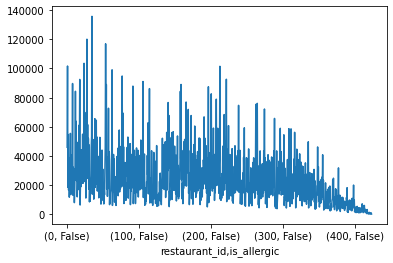

In [24]:
revenue_per_restaurant.plot()

In [54]:

revenue_per_restaurant

restaurant_id  is_allergic
0              False           45902.7
               True           101683.0
1              False           18403.4
               True            54626.6
2              False           16431.5
                                ...   
421            True              567.1
422            False             116.9
               True              652.2
423            True              891.7
424            True               64.8
Name: total, Length: 848, dtype: float64

In [48]:
revenue_per_restaurant.index.get_level_values('is_allergic')

Index([False,  True, False,  True, False,  True, False,  True, False,  True,
       ...
       False,  True, False,  True, False,  True, False,  True,  True,  True],
      dtype='object', name='is_allergic', length=848)

In [51]:
df = revenue_per_restaurant.reset_index()

<AxesSubplot:xlabel='restaurant_id', ylabel='total'>

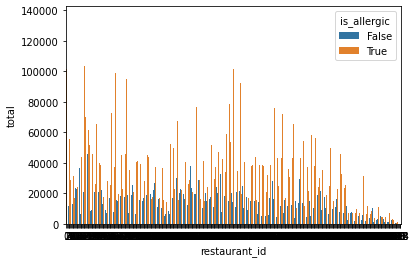

In [56]:
import seaborn as sns

sns.barplot(x="restaurant_id", y="total", hue="is_allergic", data=df)

In [55]:
df

,restaurant_id,is_allergic,total
0,0,False,45902.7
1,0,True,101683.0
2,1,False,18403.4
3,1,True,54626.6
4,2,False,16431.5
...,...,...,...
843,421,True,567.1
844,422,False,116.9
845,422,True,652.2
846,423,True,891.7
